# Test case 2D-2 (unsteady)

In [1]:
import numpy as np
import time
import scipy.sparse.linalg as sp_la
import matplotlib.pyplot as plt
import numba
import os

# --- Numba configuration ---
try:
    num_cores = os.cpu_count()
    numba.set_num_threads(num_cores)
    print(f"Numba is set to use {numba.get_num_threads()} threads.")
except (ImportError, AttributeError):
    print("Numba not found or configured. Running in pure Python mode.")

# --- Core pycutfem imports ---
from pycutfem.core.mesh import Mesh
from pycutfem.core.dofhandler import DofHandler
from pycutfem.utils.meshgen import structured_quad
from pycutfem.fem.mixedelement import MixedElement
from pycutfem.core.levelset import CircleLevelSet
from pycutfem.utils.domain_manager import get_domain_bitset
from pycutfem.core.geometry import hansbo_cut_ratio

# --- UFL-like imports ---
from pycutfem.ufl.functionspace import FunctionSpace
from pycutfem.ufl.expressions import (
    TrialFunction, TestFunction, VectorTrialFunction, VectorTestFunction,
    Function, VectorFunction, Constant, grad, inner, dot, div, jump, avg,
    FacetNormal, CellDiameter, Pos, Neg, ElementWiseConstant, restrict,
)
from pycutfem.ufl.measures import dx, dS, dGhost, dInterface
from pycutfem.ufl.forms import BoundaryCondition, Equation
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters
from pycutfem.ufl.compilers import FormCompiler


Numba: Using NumPy 2.1.3 (/home/bhatti/anaconda3/envs/pycutfem/lib/python3.13/site-packages/numpy/__init__.py)
numpy_version: (2, 1)
Numba is set to use 16 threads.


In [2]:
# ============================================================================
#    1. BENCHMARK PROBLEM SETUP
# ============================================================================
print("--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---")

# --- Geometry and Fluid Properties ---
H = 0.41  # Channel height
L = 2.2   # Channel length
D = 0.1   # Cylinder diameter
c_x, c_y = 0.2, 0.2  # Cylinder center
rho_f = 1.0  # Density for fluid
rho_s = 1000.0  # Density for solid
mu_f = 1e-3  # Viscosity for fluid
U_max = 1.0 # Max inflow velocity
U_mean = 3.0/2.0 * U_max # Mean inflow velocity
# Lame coefficients for solid
_lambda_s = 0.5e6 # Lame's first parameter for solid
_mu_s = 2.0e6   # Lame's second parameter for solid
# beta_penalty = max(mu_f, _mu_s)   # Nitsche penalty parameter
beta_penalty = 90.0 * mu_f   # Nitsche penalty parameter
Re = rho_f * U_max * D / mu_f
print(f"Reynolds number (Re): {Re:.2f}")
with_ghost_enabled = False
hessian_ghost_enabled = False

--- Setting up the Turek benchmark (2D-2) for flow around a cylinder ---
Reynolds number (Re): 100.00


In [3]:
from pycutfem.utils.adaptive_mesh_ls_numba import structured_quad_levelset_adaptive
# from pycutfem.utils.adaptive_mesh import structured_quad_levelset_adaptive
# --- Mesh ---
# A finer mesh is needed for this benchmark
NX, NY = 40, 25
# NX, NY = 50, 60
poly_order = 2
level_set = CircleLevelSet(center=(c_x, c_y), radius=D/2.0 ) # needs to correct the radius, also cx modified for debugging

# nodes, elems, _, corners = structured_quad(L, H, nx=NX, ny=NY, poly_order=poly_order)

nodes, elems, edges, corners = structured_quad_levelset_adaptive(
        Lx=L, Ly=H, nx=NX, ny=NY, poly_order=poly_order,
        level_set=CircleLevelSet(center=(c_x, c_y), radius=(D/2.0+0.1*D/2.0) ),
        max_refine_level=1)          # add a single halo, nothing else
mesh = Mesh(nodes=nodes, element_connectivity=elems, elements_corner_nodes=corners, element_type="quad", poly_order=poly_order)

# ============================================================================
#    2. BOUNDARY CONDITIONS
# ============================================================================

# --- Tag Boundaries ---
bc_tags = {
    'inlet':  lambda x, y: np.isclose(x, 0),
    'outlet': lambda x, y: np.isclose(x, L),
    'walls':  lambda x, y: np.isclose(y, 0) | np.isclose(y, H),
}


# --- Define Parabolic Inflow Profile ---
def parabolic_inflow(x, y):
    return 4 * U_mean * y * (H - y) / (H**2)

# --- Define Boundary Conditions List ---
bcs = [
    BoundaryCondition('u_pos_x', 'dirichlet', 'inlet', parabolic_inflow),
    BoundaryCondition('u_pos_y', 'dirichlet', 'inlet', lambda x, y: 0.0),
    BoundaryCondition('u_pos_x', 'dirichlet', 'walls', lambda x, y: 0.0),
    BoundaryCondition('u_pos_y', 'dirichlet', 'walls', lambda x, y: 0.0),
    # No-slip on the cylinder is handled by the CutFEM formulation
    # "Do-nothing" at the outlet is the natural BC
]

# Homogeneous BCs for Jacobian assembly
bcs_homog = [BoundaryCondition(bc.field, bc.method, bc.domain_tag, lambda x, y: 0.0) for bc in bcs]



In [4]:
# --- Level Set for the Cylinder Obstacle ---


mesh.classify_elements(level_set)
mesh.classify_edges(level_set)
mesh.build_interface_segments(level_set=level_set)
mesh.tag_boundary_edges(bc_tags)

# --- Define Domains with BitSets ---
fluid_domain = get_domain_bitset(mesh, "element", "outside")
solid_domain = get_domain_bitset(mesh, "element", "inside")
cut_domain = get_domain_bitset(mesh, "element", "cut")
ghost_edges = get_domain_bitset(mesh, "edge", "ghost")
fluid_interface_domain = fluid_domain | cut_domain
solid_interface_domain = solid_domain | cut_domain
has_pos = fluid_domain | cut_domain
has_neg = solid_domain | cut_domain
solid_ghost_edges = mesh.edge_bitset('ghost_neg')  | mesh.edge_bitset('interface') #| mesh.edge_bitset('ghost_both')
fluid_ghost_edges = mesh.edge_bitset('ghost_pos')  | mesh.edge_bitset('interface') #| mesh.edge_bitset('ghost_both')

# --- Finite Element Space and DofHandler ---
# Taylor-Hood elements (Q2 for velocity, Q1 for pressure)
poly_order = 2

mixed_element = MixedElement(mesh, field_specs={'u_pos_x': poly_order, 'u_pos_y': poly_order, 
                                                'p_pos_': poly_order - 1,
                                                'vs_neg_x':poly_order - 1, 'vs_neg_y':poly_order - 1,
                                                'd_neg_x':poly_order - 1,'d_neg_y':poly_order - 1,
                                                })
dof_handler = DofHandler(mixed_element, method='cg')
# dof_handler.info()

print(f"Number of interface edges: {mesh.edge_bitset('interface').cardinality()}")
print(f"Number of ghost edges: {ghost_edges.cardinality()}")
print(f"Number of cut elements: {cut_domain.cardinality()}")
print(f"Number of fluid elements: {fluid_domain.cardinality()}")
print(f"Number of solid elements: {solid_domain.cardinality()}")
print(f"Number of solid ghost edges: {solid_ghost_edges.cardinality()}")
print(f"Number of fluid ghost edges: {fluid_ghost_edges.cardinality()}")


Number of interface edges: 32
Number of ghost edges: 63
Number of cut elements: 32
Number of fluid elements: 1324
Number of solid elements: 20
Number of solid ghost edges: 58
Number of fluid ghost edges: 68


In [5]:
dof_handler.tag_dofs_from_element_bitset("inactive", "u_pos_x", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "u_pos_y", "inside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "p_pos_", "inside", strict=True)

dof_handler.tag_dofs_from_element_bitset("inactive", "vs_neg_x", "outside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "vs_neg_y", "outside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "d_neg_x", "outside", strict=True)
dof_handler.tag_dofs_from_element_bitset("inactive", "d_neg_y", "outside", strict=True)



{16385,
 8199,
 8200,
 16398,
 8213,
 16411,
 34,
 35,
 36,
 37,
 16424,
 8234,
 8235,
 16437,
 8248,
 58,
 59,
 16450,
 8261,
 16463,
 8274,
 16476,
 94,
 95,
 96,
 97,
 8287,
 16489,
 8300,
 118,
 119,
 8313,
 16506,
 8326,
 16519,
 140,
 141,
 8339,
 16532,
 8352,
 16545,
 162,
 163,
 8365,
 16558,
 184,
 185,
 8378,
 16571,
 8391,
 16584,
 206,
 207,
 8404,
 16597,
 8417,
 16610,
 228,
 229,
 8430,
 16623,
 250,
 251,
 8443,
 16636,
 8456,
 16649,
 272,
 273,
 8469,
 16662,
 8482,
 294,
 295,
 16679,
 8495,
 16692,
 316,
 317,
 8508,
 16705,
 8521,
 16718,
 338,
 339,
 8534,
 16731,
 8547,
 360,
 361,
 16744,
 8560,
 16757,
 8573,
 382,
 383,
 16770,
 8586,
 16783,
 404,
 405,
 8599,
 16796,
 8612,
 16809,
 426,
 427,
 8625,
 16822,
 8638,
 448,
 449,
 16835,
 8651,
 16852,
 470,
 471,
 8664,
 16865,
 8677,
 492,
 493,
 16878,
 8698,
 8699,
 16891,
 514,
 515,
 8712,
 16904,
 16917,
 536,
 537,
 8733,
 8734,
 16930,
 8747,
 558,
 559,
 16943,
 8760,
 16956,
 580,
 581,
 8773,
 1696

In [6]:
# contraining the displacement and velocity of solid to zero for cyclinder center
# 1. Define the target point.
target_point = np.array([c_x,c_y])

# 2. Get all node IDs that have a pressure DOF associated with them.
pin_dofs = dof_handler.get_field_slice('vs_neg_x')
pin_node_ids = np.array([dof_handler._dof_to_node_map[dof][1] for dof in pin_dofs])

# 3. Get the coordinates of ONLY these pressure-carrying nodes.
pin_node_coords = mesh.nodes_x_y_pos[pin_node_ids]

# 4. Find the node closest to the target point WITHIN this restricted set.
distances = np.linalg.norm(pin_node_coords - target_point, axis=1)
local_index = np.argmin(distances)

# 5. Get the global ID and actual coordinates of that specific pressure node.
closest_p_node_id = pin_node_ids[local_index]
actual_pin_coords = mesh.nodes_x_y_pos[closest_p_node_id]
print(f"Pinning pressure at the node closest to {target_point}, found at {actual_pin_coords}")
for field in ['vs_neg_x', 'vs_neg_y', 'd_neg_x', 'd_neg_y']:
    tag_name = f'pinning_{field}'
    dof_handler.tag_dof_by_locator(
        tag_name, field,
        locator=lambda x, y, x0=actual_pin_coords[0], y0=actual_pin_coords[1]: 
            np.isclose(x, x0) and np.isclose(y, y0),
        find_first=True
    )
    bcs.append(
        BoundaryCondition(field, 'dirichlet', tag_name, lambda x, y: 0.0)
    )
    bcs_homog.append(
        BoundaryCondition(field, 'dirichlet', tag_name, lambda x, y: 0.0)
    )


Pinning pressure at the node closest to [0.2 0.2], found at [0.1925 0.1968]


In [7]:
print(f'Total dirchlet dofs: {len(dof_handler.get_dirichlet_data(bcs))}')

Total dirchlet dofs: 478


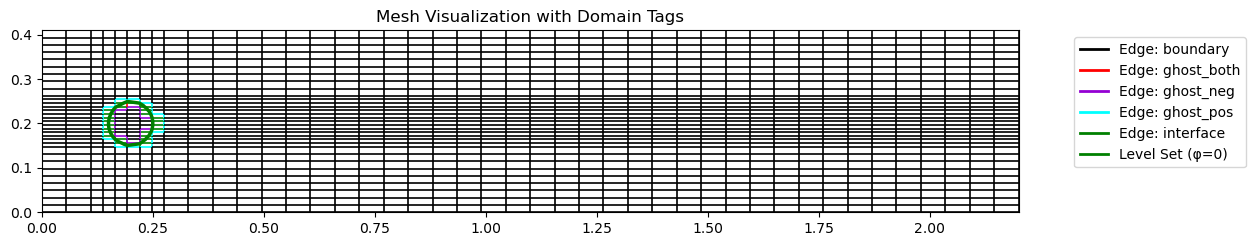

<Axes: title={'center': 'Mesh Visualization with Domain Tags'}>

In [8]:
from pycutfem.io.visualization import plot_mesh_2
fig, ax = plt.subplots(figsize=(15, 30))
plot_mesh_2(mesh, ax=ax, level_set=level_set, show=True, 
              plot_nodes=False, elem_tags=False, edge_colors=True, plot_interface=False,resolution=300)

In [9]:
# ============================================================================
#    3. UFL FORMULATION WITH GHOST PENALTY
# ============================================================================
print("\n--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---")

# --- Function Spaces and Functions ---
velocity_fluid_space = FunctionSpace(name="velocity_fluid", field_names=['u_pos_x', 'u_pos_y'],dim=1, side='+')
pressure_fluid_space = FunctionSpace(name="pressure_fluid", field_names=['p_pos_'], dim=0, side='+')
velocity_solid_space = FunctionSpace(name="velocity_solid", field_names=['vs_neg_x', 'vs_neg_y'], dim=1, side='-')
displacement_space = FunctionSpace(name="displacement", field_names=['d_neg_x', 'd_neg_y'], dim=1, side='-')
# Trial and Test functions
du_f = VectorTrialFunction(space=velocity_fluid_space, dof_handler=dof_handler)
dp_f = TrialFunction(name='trial_pressure_fluid', field_name='p_pos_', dof_handler=dof_handler, side='+')
du_s = VectorTrialFunction(space=velocity_solid_space, dof_handler=dof_handler)
ddisp_s = VectorTrialFunction(space=displacement_space, dof_handler=dof_handler)
test_vel_f = VectorTestFunction(space=velocity_fluid_space, dof_handler=dof_handler)
test_q_f = TestFunction(name='test_pressure_fluid', field_name='p_pos_', dof_handler=dof_handler, side='+')
test_vel_s = VectorTestFunction(space=velocity_solid_space, dof_handler=dof_handler)
test_disp_s = VectorTestFunction(space=displacement_space, dof_handler=dof_handler)

# Solution functions at current (k) and previous (n) time steps
uf_k = VectorFunction(name="u_f_k", field_names=['u_pos_x', 'u_pos_y'], dof_handler=dof_handler, side='+')
pf_k = Function(name="p_f_k", field_name='p_pos_', dof_handler=dof_handler, side='+')
uf_n = VectorFunction(name="u_f_n", field_names=['u_pos_x', 'u_pos_y'], dof_handler=dof_handler, side='+')
pf_n = Function(name="p_f_n", field_name='p_pos_', dof_handler=dof_handler, side='+')
us_k = VectorFunction(name="u_s_k", field_names=['vs_neg_x', 'vs_neg_y'], dof_handler=dof_handler, side='-')
us_n = VectorFunction(name="u_s_n", field_names=['vs_neg_x', 'vs_neg_y'], dof_handler=dof_handler, side='-')
disp_k = VectorFunction(name="disp_k", field_names=['d_neg_x', 'd_neg_y'], dof_handler=dof_handler, side='-')
disp_n = VectorFunction(name="disp_n", field_names=['d_neg_x', 'd_neg_y'], dof_handler=dof_handler, side='-')

# --- Parameters ---
dt = Constant(0.2)
theta = Constant(1.0) # Crank-Nicolson
mu_f_const = Constant(mu_f)
rho_f_const = Constant(rho_f)
rho_s_const = Constant(rho_s)
mu_s = Constant(_mu_s) # Lame's second parameter for solid
lambda_s = Constant(_lambda_s)  # Lame's first parameter for solid

uf_k.nodal_values.fill(0.0); pf_k.nodal_values.fill(0.0)
uf_n.nodal_values.fill(0.0); pf_n.nodal_values.fill(0.0)
us_k.nodal_values.fill(0.0); us_n.nodal_values.fill(0.0)
disp_k.nodal_values.fill(0.0); disp_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, uf_n, pf_n, us_n, disp_n)


--- Defining the UFL weak form for Navier-Stokes with ghost penalty ---


Plotting all components of 'u_f_n' as separate contour plots...


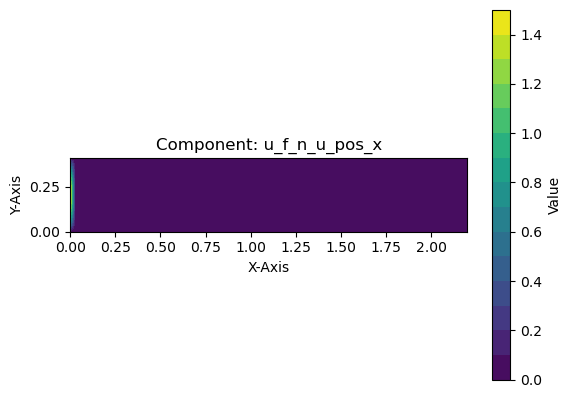

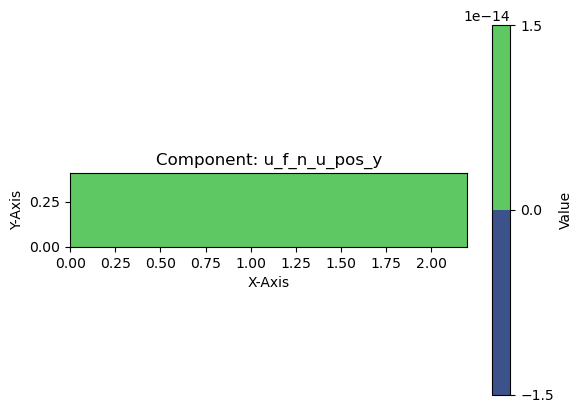

In [10]:
uf_n.plot()

In [11]:
from pycutfem.ufl.expressions import (
    Derivative, FacetNormal, trace, Jump, Hessian,
    Pos, Neg, ElementWiseConstant, restrict,
)

n = FacetNormal()                    # vector expression (n_x, n_y)



def grad_inner_jump(u, v):
    a = dot(jump(grad(u)), n)
    b = dot(jump(grad(v)), n)
    return inner(a, b)

def hess_inner_jump(u, v):
    a = dot(n, dot(jump(Hessian(u)), n))
    b = dot(n, dot(jump(Hessian(v)), n))
    return inner(a, b)

qvol = 6
dx_fluid = dx(
    defined_on=fluid_interface_domain,
    level_set=level_set,
    metadata={"q": qvol, "side": "+"},
)
dx_solid = dx(
    defined_on=solid_interface_domain,
    level_set=level_set,
    metadata={"q": qvol, "side": "-"},
)
dΓ = dInterface(
    defined_on=mesh.element_bitset("cut"),
    level_set=level_set,
    metadata={"q": qvol + 2, "derivs": {(0, 0), (0, 1), (1, 0)}},
)
if hessian_ghost_enabled:
    dG_fluid = dGhost(
        defined_on=fluid_ghost_edges,
        level_set=level_set,
        metadata={"q": qvol, "derivs": {(0, 0), (0, 1), (1, 0), (2, 0), (0, 2), (1, 1)}},
    )
    dG_solid = dGhost(
        defined_on=solid_ghost_edges,
        level_set=level_set,
        metadata={"q": qvol, "derivs": {(0, 0), (0, 1), (1, 0), (2, 0), (0, 2), (1, 1)}},
    )
else:
    dG_fluid = dGhost(
        defined_on=fluid_ghost_edges,
        level_set=level_set,
        metadata={"q": qvol, "derivs": {(0, 1), (1, 0)}},
    )
    dG_solid = dGhost(
        defined_on=solid_ghost_edges,
        level_set=level_set,
        metadata={"q": qvol, "derivs": {(0, 1), (1, 0)}},
    )

cell_h = CellDiameter()
beta_N = Constant(beta_penalty * poly_order * (poly_order + 1))

theta_min = 1.0e-3
theta_pos_vals = np.clip(hansbo_cut_ratio(mesh, level_set, side="+"), theta_min, 1.0)
theta_neg_vals = np.clip(hansbo_cut_ratio(mesh, level_set, side="-"), theta_min, 1.0)
kappa_pos = Pos(ElementWiseConstant(theta_pos_vals))
kappa_neg = Neg(ElementWiseConstant(theta_neg_vals))
use_restricted_forms = False
if use_restricted_forms:
    du_f_R =        restrict(du_f, has_pos)
    dp_f_R =        restrict(dp_f, has_pos)
    test_vel_f_R =  restrict(test_vel_f, has_pos)
    test_q_f_R =    restrict(test_q_f, has_pos)
    uf_k_R =        restrict(uf_k, has_pos)
    uf_n_R =        restrict(uf_n, has_pos)
    pf_k_R =        restrict(pf_k, has_pos)
    pf_n_R =        restrict(pf_n, has_pos)

    du_s_R =        restrict(du_s, has_neg)
    ddisp_s_R =     restrict(ddisp_s, has_neg)
    test_vel_s_R =  restrict(test_vel_s, has_neg)
    test_disp_s_R = restrict(test_disp_s, has_neg)
    us_k_R =        restrict(us_k, has_neg)
    us_n_R =        restrict(us_n, has_neg)
    disp_k_R =      restrict(disp_k, has_neg)
    disp_n_R =      restrict(disp_n, has_neg)
else:
    du_f_R =        du_f
    dp_f_R =        dp_f
    test_vel_f_R =  test_vel_f
    test_q_f_R =    test_q_f
    uf_k_R =        uf_k
    uf_n_R =        uf_n
    pf_k_R =        pf_k
    pf_n_R =        pf_n
    du_s_R =        du_s
    ddisp_s_R =     ddisp_s
    test_vel_s_R =  test_vel_s
    test_disp_s_R = test_disp_s
    us_k_R =        us_k
    us_n_R =        us_n
    disp_k_R =      disp_k
    disp_n_R =      disp_n

I2 = Constant(np.eye(2))

def epsilon_f(u):
    return 0.5 * (grad(u) + grad(u).T)

def epsilon_s_linear_L(disp, disp_k):
    return 0.5 * (
        grad(disp) + grad(disp).T
        + dot(grad(disp).T, grad(disp_k))
        + dot(grad(disp_k).T, grad(disp))
    )

def epsilon_s_linear_R(disp_k):
    return 0.5 * (
        grad(disp_k) + grad(disp_k).T
        + dot(grad(disp_k).T, grad(disp_k))
    )

def sigma_s_linear_weak_L(ddisp, disp_k, grad_v_test):
    eps = epsilon_s_linear_L(ddisp, disp_k)
    return 2.0 * mu_s * inner(eps, grad_v_test) + lambda_s * trace(eps) * trace(grad_v_test)

def sigma_s_linear_weak_R(disp_k, grad_v_test):
    eps = epsilon_s_linear_R(disp_k)
    return 2.0 * mu_s * inner(eps, grad_v_test) + lambda_s * trace(eps) * trace(grad_v_test)

def traction_fluid(u_vec, p_scal):
    return 2.0 * mu_f_const * dot(epsilon_f(u_vec), n) - p_scal * n

def traction_solid_L(disp_inc, disp_ref):
    eps = epsilon_s_linear_L(disp_inc, disp_ref)
    sigma = 2.0 * mu_s * eps + lambda_s * trace(eps) * I2
    return dot(sigma, n)

def traction_solid_R(disp_ref):
    eps = epsilon_s_linear_R(disp_ref)
    sigma = 2.0 * mu_s * eps + lambda_s * trace(eps) * I2
    return dot(sigma, n)

def sigma_dot_n_v(u_vec, p_scal, v_test):
    a = dot(grad(u_vec), n)
    b = dot(grad(u_vec).T, n)
    return mu_f * dot(a + b, v_test) - p_scal * dot(v_test, n)

jump_vel_trial = Jump(du_f, du_s)
jump_vel_test = Jump(test_vel_f, test_vel_s)
jump_vel_res = Jump(uf_k, us_k)

avg_flux_trial = (
    kappa_pos * traction_fluid(Pos(du_f), Pos(dp_f))
    - kappa_neg * traction_solid_L(Neg(ddisp_s), Neg(disp_k))
)

avg_flux_test = (
    kappa_pos * traction_fluid(Pos(test_vel_f),- Pos(test_q_f))
    - kappa_neg * traction_solid_L(Neg(test_disp_s), Neg(disp_k))
)

avg_flux_res = (
    kappa_pos * traction_fluid(Pos(uf_k), Pos(pf_k))
    - kappa_neg * traction_solid_R(Neg(disp_k))
)

# reduced setup without jumps
# jump_vel_trial = du_f_R - du_s_R
# jump_vel_test = test_vel_f_R - test_vel_s_R
# jump_vel_res = uf_k_R - us_k_R
# avg_flux_trial = (
#     kappa_pos * traction_fluid(du_f_R, dp_f_R)
#     - kappa_neg * traction_solid_L(ddisp_s_R, disp_k_R)
# )

# avg_flux_test = (
#     kappa_pos * traction_fluid(test_vel_f_R, test_q_f_R)
#     - kappa_neg * traction_solid_L(test_vel_s_R, disp_k_R)
# )

# avg_flux_res = (
#     kappa_pos * traction_fluid(uf_k_R, pf_k_R)
#     - kappa_neg * traction_solid_R(disp_k_R)
# )


# J_int = (
#     - dot(avg_flux_trial, jump_vel_test)
#     - dot(avg_flux_test, jump_vel_trial)
#     + (beta_N * mu_f / cell_h) * dot(jump_vel_trial, jump_vel_test)
# ) * dΓ

# R_int = (
#     - dot(avg_flux_res, jump_vel_test)
#     - dot(avg_flux_test, jump_vel_res)
#     + (beta_N * mu_f / cell_h) * dot(jump_vel_res, jump_vel_test)
# ) * dΓ
J_int = (
     dot(avg_flux_trial, jump_vel_test)
    + dot(avg_flux_test, jump_vel_trial)
    + (beta_N * mu_f / cell_h) * dot(jump_vel_trial, jump_vel_test)
) * dΓ

R_int = (
     dot(avg_flux_res, jump_vel_test)
    + dot(avg_flux_test, jump_vel_res)
    + (beta_N * mu_f / cell_h) * dot(jump_vel_res, jump_vel_test)
) * dΓ

a_vol_f = (
    rho_f_const / dt * dot(du_f_R, test_vel_f_R)
    + theta * rho_f_const * dot(dot(grad(uf_k_R), du_f_R), test_vel_f_R)
    + theta * rho_f_const * dot(dot(grad(du_f_R), uf_k_R), test_vel_f_R)
    + theta * mu_f_const * inner(grad(du_f_R), grad(test_vel_f_R))
    - dp_f_R * div(test_vel_f_R)
    + test_q_f_R * div(du_f_R)
) * dx_fluid

r_vol_f = (
    rho_f_const * dot(uf_k_R - uf_n_R, test_vel_f_R) / dt
    + theta * rho_f_const * dot(dot(grad(uf_k_R), uf_k_R), test_vel_f_R)
    + (1 - theta) * rho_f_const * dot(dot(grad(uf_n_R), uf_n_R), test_vel_f_R)
    + theta * mu_f_const * inner(grad(uf_k_R), grad(test_vel_f_R))
    + (1 - theta) * mu_f_const * inner(grad(uf_n_R), grad(test_vel_f_R))
    - pf_k_R * div(test_vel_f_R)
    + test_q_f_R * div(uf_k_R)
) * dx_fluid

a_vol_s = (
    rho_s * dot(du_s_R, test_vel_s_R) / dt
    + theta * sigma_s_linear_weak_L(ddisp_s_R, disp_k_R, grad(test_vel_s_R))
) * dx_solid

r_vol_s = (
    rho_s * dot(us_k_R - us_n_R, test_vel_s_R) / dt
    + theta * sigma_s_linear_weak_R(disp_k_R, grad(test_vel_s_R))
    + (1 - theta) * sigma_s_linear_weak_R(disp_n_R, grad(test_vel_s_R))
) * dx_solid

a_svc = (
    dot(ddisp_s_R, test_disp_s_R) / dt
    - theta * dot(du_s_R, test_disp_s_R)
) * dx_solid

r_svc = (
    dot(disp_k_R - disp_n_R, test_disp_s_R) / dt
    - theta * dot(us_k_R, test_disp_s_R)
    - (1 - theta) * dot(us_n_R, test_disp_s_R)
) * dx_solid

penalty_val = 1e-3
penalty_grad = 1e-3
penalty_hess = 1e-3
gamma_v = Constant(penalty_val * poly_order**2)
gamma_v_grad = Constant(penalty_grad * poly_order**2)
gamma_p = Constant(penalty_val * poly_order)
gama_p_grad = Constant(penalty_grad * poly_order)

def g_v_f(gamma, phi_1, phi_2):
    if hessian_ghost_enabled:
        return gamma * (
            cell_h * grad_inner_jump(phi_1, phi_2)
            + cell_h**3.0 / 4.0 * hess_inner_jump(phi_1, phi_2)
        )
    return gamma * (cell_h * grad_inner_jump(phi_1, phi_2))

def g_p(gamma, phi_1, phi_2):
    return gamma * (cell_h**3.0 * grad_inner_jump(phi_1, phi_2))

def g_v_s(gamma, phi_1, phi_2):
    return gamma * (cell_h**3.0 * grad_inner_jump(phi_1, phi_2))

def g_disp_s(gamma, phi_1, phi_2):
    return gamma * (cell_h * grad_inner_jump(phi_1, phi_2))

a_stab = (
    (
        Constant(2.0) * mu_f_const * g_v_f(gamma_v, du_f_R, test_vel_f_R)
        + g_p(gamma_p, dp_f_R, test_q_f_R)
    )
    * dG_fluid
    + (
        rho_s_const * g_v_s(gamma_v, du_s_R, test_vel_s_R)
        + Constant(2.0) * mu_s * g_disp_s(gamma_v_grad, ddisp_s_R, test_disp_s_R)
    )
    * dG_solid
)

r_stab = (
    (
        Constant(2.0) * mu_f_const * g_v_f(gamma_v, uf_k_R, test_vel_f_R)
        + g_p(gamma_p, pf_k_R, test_q_f_R)
    )
    * dG_fluid
    + (
        rho_s_const * g_v_s(gamma_v, us_k_R, test_vel_s_R)
        + Constant(2.0) * mu_s * g_disp_s(gamma_v_grad, disp_k_R, test_disp_s_R)
    )
    * dG_solid
)

jacobian_form = a_vol_f + J_int + a_vol_s + a_svc + a_stab
residual_form = r_vol_f + R_int + r_vol_s + r_svc + r_stab
# jacobian_form = a_vol_f  + a_vol_s + a_svc + a_stab
# residual_form = r_vol_f  + r_vol_s + r_svc + r_stab




In [12]:
# !rm ~/.cache/pycutfem_jit/*

In [13]:
# from pycutfem.ufl.forms import assemble_form
# K,F=assemble_form(jacobian_form==-residual_form, dof_handler=dof_handler, bcs=bcs_homog)
# print(np.linalg.norm(F, ord=np.inf))

In [14]:
from pycutfem.solvers.nonlinear_solver import NewtonSolver, NewtonParameters, TimeStepperParameters#, AdamNewtonSolver
# from pycutfem.solvers.aainhb_solver import AAINHBSolver           # or get_solver("aainhb")

uf_k.nodal_values.fill(0.0); pf_k.nodal_values.fill(0.0)
uf_n.nodal_values.fill(0.0); pf_n.nodal_values.fill(0.0)
us_k.nodal_values.fill(1.0); us_n.nodal_values.fill(0.0)
disp_k.nodal_values.fill(2.0); disp_n.nodal_values.fill(0.0)
dof_handler.apply_bcs(bcs, uf_n, pf_n, us_n, disp_n)
dof_handler.apply_bcs(bcs, uf_k, pf_k, us_k, disp_k)

# build residual_form, jacobian_form, dof_handler, mixed_element, bcs, bcs_homog …
time_params = TimeStepperParameters(dt=dt.value,max_steps=36 ,stop_on_steady=True, steady_tol=1e-6, theta= theta.value)

solver = NewtonSolver(
    residual_form, jacobian_form,
    dof_handler=dof_handler,
    mixed_element=mixed_element,
    bcs=bcs, bcs_homog=bcs_homog,
    newton_params=NewtonParameters(newton_tol=1e-6, line_search=True),
)
# primary unknowns
functions      = [uf_k, pf_k, us_k, disp_k]
prev_functions = [uf_n, pf_n, us_n, disp_n]
# solver = AdamNewtonSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6)
# )
# solver = AAINHBSolver(
#     residual_form, jacobian_form,
#     dof_handler=dof_handler,
#     mixed_element=mixed_element,
#     bcs=bcs, bcs_homog=bcs_homog,
#     newton_params=NewtonParameters(newton_tol=1e-6),
# )



solver.solve_time_interval(functions=functions,
                           prev_functions= prev_functions,
                           time_params=time_params,)

JIT cache miss → compiling _pycutfem_kernel_90d4a45c4578634f465956cffd615e0fee48995de44a006fdbe4debffe254588.py
JIT cache miss → compiling _pycutfem_kernel_066a6500894640f5c92e93a092ff3e355ac485179f8bad7924ec7a1d80a4afe8.py
No Restriction operators found. All DOFs are considered active.
NewtonSolver: Reduced system with 12450/18570 DOFs.
  Dirichlet DOFs detected: 478; Free DOFs: 12450
  Inactive DOFs tagged: 5642 (unique)
  Inactive DOFs dropped: 5642
        Newton 1: |R|_∞ = 1.78e-02, time = 956.2658503060229s
        Armijo search accepted α = 7.81e-03
          timings: assembly=9.563e+02s, solve=3.216e-01s, line-search=2.235e+00s
        Newton 2: |R|_∞ = 1.77e-02, time = 3.081011616042815s
        Line search failed – no descent.
          timings: assembly=5.097e-01s, solve=3.231e-01s, line-search=2.158e+00s
        Newton 3: |R|_∞ = 1.77e-02, time = 3.0345131219364703s
        Line search failed – no descent.
          timings: assembly=5.363e-01s, solve=3.334e-01s, line-searc

SystemError: CPUDispatcher(<function kernel at 0x7e0af176d080>) returned a result with an exception set

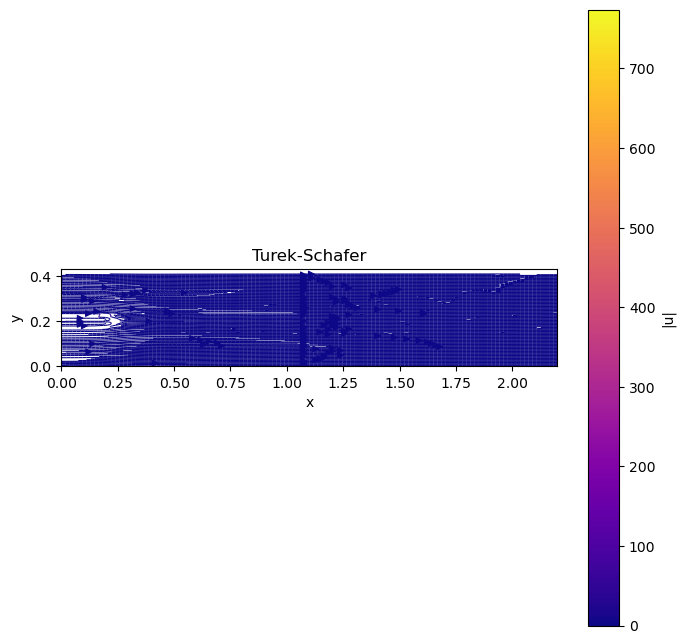

In [ ]:
uf_n.plot(kind="streamline",
         density=4.0,
         linewidth=0.8,
         cmap="plasma",
         title="Turek-Schafer",background = False)